In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from matplotlib.path import Path
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from cell_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded')

xgboost is not loaded

In [3]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (100 um, 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Generate training addresses: {structure name : stack, sec, patch_indices}

In [4]:
training_addresses_by_section = []

# for stack in all_annotated_nissl_stacks:
for stack in ['MD589']:
    first_sec, last_sec = metadata_cache['section_limits'][stack]
    
    t1 = time.time()
    
    contours_df = read_hdf(ANNOTATION_ROOTDIR + '/%(stack)s/%(stack)s_annotation_v3.h5' % dict(stack=stack), 'contours')
    labeled_contours = contours_df[(contours_df['orientation'] == 'sagittal') & (contours_df['downsample'] == 1)]
    labeled_contours = labeled_contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'downsample', 'creator'])
    labeled_contours = convert_annotation_v3_original_to_aligned_cropped(labeled_contours, stack=stack)
    
    sys.stderr.write('Load annotation. Time: %.2s seconds.\n' % (time.time() - t1))
    
    def label_region_for_one_section(sec, num_sample_per_label=10):
    
        training_addresses = {}

        if is_invalid(stack=stack, sec=sec):
            return

        region_contours = bp.unpack_ndarray_file(get_cell_classifier_data_filepath(what='region_contours', stack=stack, sec=sec, ext='bp'))
        region_labels = label_regions(stack=stack, section=sec, region_contours=region_contours,
                                      surround_margins=margins_to_sample,
                                      labeled_contours=labeled_contours[labeled_contours['section'] == sec])

        for label, region_indices in region_labels.iteritems():
            if label == 'bg' or len(region_indices) == 0:
                continue
            sampled_region_indices = np.random.choice(region_indices, min(num_sample_per_label, len(region_indices)), replace=False)
            training_addresses[label] = [(stack, sec, ridx) for ridx in sampled_region_indices]

        return training_addresses
    
    t1 = time.time()
    
    pool = Pool(NUM_CORES/2)
    training_addresses_by_section_curr_stack = pool.map(lambda sec: label_region_for_one_section(sec), range(first_sec, last_sec+1))
    pool.close()
    pool.join()
    
    training_addresses_by_section += training_addresses_by_section_curr_stack
    
    sys.stderr.write('Sample training addresses. Time: %.2s seconds.\n' % (time.time() - t1)) # 13 seconds.
    
training_addresses = defaultdict(list)
for train_addrs_by_label in training_addresses_by_section:
    if train_addrs_by_label is None: continue
    for label, addrs in train_addrs_by_label.iteritems():
        training_addresses[label] += addrs

IOError: File /shared/CSHL_labelings_v3/MD589/MD589_annotation_v3.h5 does not exist

In [29]:
training_addresses

defaultdict(list,
            {'10N': [('MD589', 210, 36467),
              ('MD589', 210, 36796),
              ('MD589', 210, 37121),
              ('MD589', 210, 37448),
              ('MD589', 211, 36857),
              ('MD589', 211, 37524),
              ('MD589', 229, 41010),
              ('MD589', 229, 41148),
              ('MD589', 232, 40260),
              ('MD589', 232, 39643)],
             '10N_negative': [('MD589', 203, 29064),
              ('MD589', 203, 37724),
              ('MD589', 203, 381),
              ('MD589', 203, 20207),
              ('MD589', 203, 2316),
              ('MD589', 203, 6201),
              ('MD589', 203, 4499),
              ('MD589', 203, 43632),
              ('MD589', 203, 42359),
              ('MD589', 203, 21561),
              ('MD589', 204, 39491),
              ('MD589', 204, 12957),
              ('MD589', 204, 21860),
              ('MD589', 204, 20296),
              ('MD589', 204, 23979),
              ('MD589', 204, 22512),
 

In [22]:
# Load training addresses

dataset =101

# training_addresses = load_pickle(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_addresses.pkl'))
training_addresses = load_pickle(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))

In [23]:
for label, train_addrs in training_addresses.iteritems():
    print label, '\t', len(train_addrs), 'examples'

Amb_surround_500_7N 	3 examples
12N_surround_500_AP 	11 examples
SNC_surround_500_SNR 	988 examples
SNR_surround_500_SNC 	571 examples
SNR_surround_500_PBG 	3 examples
5N 	1000 examples
Sp5I_surround_500_Sp5C 	630 examples
VCP_surround_500_noclass 	885 examples
Sp5I_surround_500_Sp5O 	1000 examples
6N_surround_500_7n 	8 examples
12N 	1000 examples
3N_surround_500_noclass 	687 examples
VCA_surround_500_VCP 	1000 examples
Pn_surround_500_noclass 	893 examples
Sp5I 	1000 examples
VCA_surround_500_noclass 	929 examples
Sp5C 	999 examples
SNC 	571 examples
SC_surround_500_IC 	999 examples
LC_surround_500_noclass 	713 examples
4N_surround_500_3N 	91 examples
DC_surround_500_VCA 	898 examples
SNR 	954 examples
DC_surround_500_VCP 	994 examples
SNC_surround_500_noclass 	987 examples
RtTg 	392 examples
Pn 	945 examples
10N 	10 examples
VLL 	986 examples
LRt_surround_500_Sp5C 	130 examples
RtTg_surround_500_Tz 	49 examples
IC_surround_500_noclass 	943 examples
PBG_surround_500_noclass 	771 examp

# Generate training features

In [34]:
def load_features_(stack, section, region_indices):
    """
    """
    
    region_features_all_regions = load_cell_classifier_data(what='region_features', stack=stack, sec=section, ext='hdf')
    # Loading hdf ~ 2 seconds.
    
    features1 = np.asarray([rf['largeOrientationHist'] for rf in region_features_all_regions])
    features2 = np.asarray([rf['largeSizeHist'] for rf in region_features_all_regions])
    features3 = np.asarray([rf['largeLargeLinkLenHist'] for rf in region_features_all_regions])
    features4 = np.asarray([rf['largeSmallLinkLenHist'] for rf in region_features_all_regions])
    
        
    f1 = features1[region_indices]
    f1n = f1/f1.sum(axis=1)[:,None].astype(np.float)
    
    f2 = features2[region_indices]
    f2n = f2/f2.sum(axis=1)[:,None].astype(np.float)
    
    f3 = features3[region_indices]
    f3n = f3/f3.sum(axis=1)[:,None].astype(np.float)
    
    f4 = features4[region_indices]
    f4n = f4/f4.sum(axis=1)[:,None].astype(np.float)
    
    features = np.c_[f1n, f2n, f3n, f4n]
    
    return features

In [35]:
t = time.time()

func_for_list = lambda addrs: smart_map(addrs, keyfunc=lambda (st, se, ri): (st, se),
                       func=lambda (st, se), gr: load_features_(st, se, [ri for _,_,ri in gr]))

training_features = apply_function_to_dict(func_for_list, 
                                           training_addresses)
#                        {i: t for i, t in training_addresses.iteritems() if i in ['7N', '5N']})

training_features = apply_function_to_dict(np.asarray, training_features)

sys.stderr.write('Load features: %.2f seconds.\n' % (time.time() - t)) # 40 seconds for 64k addresses

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value enco

In [39]:
# Remove features with invalid values.

training_addresses_invalid_removed = {}
training_features_invalid_removed = {}
for label, feats in training_features.iteritems():
    invalid_indices = np.where(np.any(np.isnan(feats), axis=1))[0]
    print label, '\t\t', len(invalid_indices)
    valid_indices = np.setdiff1d(np.arange(len(feats)), invalid_indices)
    
    training_addresses_invalid_removed[label] = [training_addresses[label][i] for i in valid_indices]
    training_features_invalid_removed[label] = training_features[label][valid_indices]    

Amb_surround_500_7N 		0
12N_surround_500_AP 		2
4N_negative 		21
AP_negative 		32
Tz_negative 		92
SNC_surround_500_SNR 		20
SNR_surround_500_SNC 		10
SNR_surround_500_PBG 		0
5N 		10
Sp5I_surround_500_Sp5C 		0
SNC_surround_500_noclass 		16
Sp5I_surround_500_Sp5O 		1
LRt_negative 		86
6N_surround_500_7n 		1
12N 		3
3N_surround_500_noclass 		15
6N_negative 		11
LC_negative 		23
Sp5O 		9
Pn_surround_500_noclass 		183
Sp5I 		0
VCA_surround_500_noclass 		107
Sp5C 		4
12N_surround_500_noclass 		38
SNC 		10
SC_surround_500_IC 		1
Amb_negative 		16
LC_surround_500_noclass 		2
4N_surround_500_3N 		2
DC_surround_500_VCA 		0
7n_negative 		161
DC_surround_500_VCP 		3
noclass 		591
3N 		6
Pn 		72
RMC_negative 		84
10N 		0
VLL 		9
LRt_surround_500_Sp5C 		0
RtTg_surround_500_Tz 		0
VCP_negative 		170
SNC_negative 		102
IC_surround_500_noclass 		225
PBG_surround_500_noclass 		3
Sp5O_negative 		105
SNR 		75
PBG_surround_500_SNR 		0
SC 		2
PBG 		0
Sp5C_negative 		141
IC_negative 		229
SNR_negative 		15

In [40]:
training_addresses = training_addresses_invalid_removed
training_features = training_features_invalid_removed

In [41]:
for label, train_addrs in training_addresses.iteritems():
    print label, '\t', len(train_addrs), 'examples'

Amb_surround_500_7N 	3 examples
12N_surround_500_AP 	11 examples
4N_negative 	99 examples
AP_negative 	118 examples
Tz_negative 	408 examples
SNC_surround_500_SNR 	810 examples
SNR_surround_500_SNC 	333 examples
SNR_surround_500_PBG 	3 examples
5N 	430 examples
Sp5I_surround_500_Sp5C 	210 examples
SNC_surround_500_noclass 	814 examples
Sp5I_surround_500_Sp5O 	369 examples
LRt_negative 	674 examples
6N_surround_500_7n 	8 examples
12N 	387 examples
3N_surround_500_noclass 	225 examples
6N_negative 	39 examples
LC_negative 	217 examples
Sp5O 	361 examples
Pn_surround_500_noclass 	827 examples
Sp5I 	499 examples
VCA_surround_500_noclass 	553 examples
Sp5C 	896 examples
Sp5O_negative 	285 examples
SNC 	333 examples
SC_surround_500_IC 	1639 examples
Amb_negative 	114 examples
LC_surround_500_noclass 	238 examples
4N_surround_500_3N 	58 examples
DC_surround_500_VCA 	313 examples
SNR 	1025 examples
DC_surround_500_VCP 	394 examples
noclass 	2139 examples
RtTg 	136 examples
Pn 	888 examples
RMC

In [42]:
# Save this set as dataset.

dataset = 99

train_feat_dir = create_if_not_exists(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features'))

# Save training features
for label, feats in training_features.iteritems():
    feats_fp = os.path.join(train_feat_dir, label + '.bp')
    bp.pack_ndarray_file(feats, feats_fp)
    
# Save training addresses
save_pickle(training_addresses, os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_addresses.pkl'))

# Load dataset

In [61]:
# Load multiple datasets

training_features = {}

for dataset in [7,8]:
    train_feat_dir = os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features')
    
    for label in labels_to_sample:
        try:
            if label not in training_features:
                training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
            else:
                training_features[label] = np.vstack([training_features[label], 
                                                     bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))])
        except Exception as e:
            continue

In [43]:
# Load a single dataset

dataset = 99

train_feat_dir = os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'region_features')

training_features = {}
for label in labels_to_sample:
    try:
        training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
    except:
        continue

In [44]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [49]:
setting = 999
setting_dir = os.path.join(os.path.join(CELL_FEATURES_CLF_ROOTDIR, 'setting_%d' % setting))
margin = 500

In [65]:
# train svm classifiers

clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:
# for structure in ['Pn']:
    
    t = time.time()
    
    if structure not in training_features:
        continue
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    ###################################
    # Define training set composition #
    ###################################
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 999]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
    
    n_neg = len(features_neg)
    
    ###########################
    ## Define Sample Weights ##
    ###########################
    
    if setting == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    sys.stderr.write('%d, %d\n' % (n_pos, n_neg))
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    ##################
    ## Define Model ##
    ##################
    
    if setting in [1, 2, 8, 9, 10, 11, 14, 15]:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
    elif setting in [3, 16]:
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif setting == 4:
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif setting in [5, 17, 18]:        
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif setting in [6,13, 19, 20]:
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif setting in [7, 21, 22, 999]:        
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        raise Exception('Setting is not recognized.')
 
    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier %s: %.2f seconds\n' % (structure, time.time() - t))
    
    joblib.dump(clf, os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting)))

481, 510


      Iter       Train Loss   Remaining Time 
         1           1.0805            0.47s
         2           0.9086            0.45s
         3           0.7939            0.45s
         4           0.7198            0.43s
         5           0.6581            0.42s
         6           0.6071            0.42s
         7           0.5630            0.41s
         8           0.5207            0.41s
         9           0.4868            0.41s
        10           0.4550            0.40s
        20           0.2334            0.34s
        30           0.1388            0.29s
        40           0.0852            0.24s
        50           0.0405            0.21s
        60           0.0240            0.17s
        70           0.0149            0.12s
        80           0.0092            0.08s
        90           0.0054            0.04s
       100           0.0033            0.00s


Fitting classifier Tz: 0.41 seconds
361, 690


      Iter       Train Loss   Remaining Time 
         1           1.1983            0.41s
         2           1.1449            0.38s
         3           1.0914            0.37s
         4           1.0425            0.37s
         5           0.9732            0.39s
         6           0.9252            0.39s
         7           0.8928            0.38s
         8           0.8613            0.38s
         9           0.8294            0.37s
        10           0.8066            0.36s
        20           0.5620            0.31s
        30           0.4046            0.27s
        40           0.2920            0.23s
        50           0.2152            0.19s
        60           0.1620            0.15s
        70           0.1323            0.11s
        80           0.0982            0.08s
        90           0.0767            0.04s
       100           0.0598            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.5892            0.32s
        

Fitting classifier Sp5O: 0.38 seconds
182, 1072


         6           0.3586            0.34s
         7           0.3358            0.34s
         8           0.3117            0.34s
         9           0.2935            0.33s
        10           0.2851            0.33s
        20           0.1749            0.29s
        30           0.1114            0.26s
        40           0.0815            0.21s
        50           0.0518            0.18s
        60           0.0340            0.14s
        70           0.0233            0.11s
        80           0.0159            0.07s
        90           0.0111            0.04s
       100           0.0078            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1710            1.06s
         2           1.0791            1.08s
         3           0.9949            1.11s
         4           0.9440            1.07s
         5           0.8893            1.07s


Fitting classifier 7n: 0.36 seconds
867, 1615


         6           0.8544            1.04s
         7           0.8165            1.04s
         8           0.7819            1.03s
         9           0.7451            1.03s
        10           0.7209            1.00s
        20           0.5283            0.86s
        30           0.4023            0.73s
        40           0.3095            0.62s
        50           0.2310            0.52s
        60           0.1730            0.41s
        70           0.1403            0.31s
        80           0.1175            0.20s
        90           0.0916            0.10s
       100           0.0700            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1603            0.35s
         2           1.0260            0.35s
         3           0.9387            0.34s
         4           0.8804            0.33s
         5           0.8008            0.35s
         6           0.7434            0.35s
         7           0.6872            0.35s
         

Fitting classifier DC: 1.01 seconds
430, 431


        60           0.0739            0.13s
        70           0.0523            0.10s
        80           0.0344            0.06s
        90           0.0246            0.03s
       100           0.0180            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1059            0.21s
         2           0.9297            0.22s
         3           0.8112            0.21s
         4           0.7185            0.21s
         5           0.6427            0.21s
         6           0.5642            0.21s
         7           0.5175            0.20s
         8           0.4729            0.20s
         9           0.4369            0.20s
        10           0.3970            0.19s
        20           0.1865            0.16s


Fitting classifier 5N: 0.32 seconds
234, 225


        30           0.0933            0.14s
        40           0.0465            0.12s
        50           0.0245            0.10s
        60           0.0132            0.08s
        70           0.0070            0.06s
        80           0.0034            0.04s
        90           0.0018            0.02s
       100           0.0009            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1758            0.78s
         2           1.0354            0.77s
         3           0.9332            0.78s
         4           0.8576            0.76s


Fitting classifier 3N: 0.19 seconds
888, 907


         5           0.7988            0.75s
         6           0.7391            0.77s
         7           0.7006            0.75s
         8           0.6654            0.73s
         9           0.6316            0.72s
        10           0.5935            0.72s
        20           0.3769            0.62s
        30           0.2612            0.53s
        40           0.1724            0.46s
        50           0.1171            0.38s
        60           0.0839            0.30s
        70           0.0624            0.23s
        80           0.0426            0.15s
        90           0.0303            0.08s
       100           0.0219            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.1244            0.21s
         2           0.0920            0.25s
         3           0.0753            0.27s
         4           0.0662            0.26s
         5           0.0542            0.26s
         6           0.0466            0.26s
         

Fitting classifier Pn: 0.76 seconds
10, 753
Fitting classifier 10N: 0.13 seconds
240, 238


         6           0.6152            0.23s
         7           0.5641            0.22s
         8           0.5187            0.22s
         9           0.4746            0.22s
        10           0.4338            0.21s
        20           0.2074            0.17s
        30           0.1115            0.15s
        40           0.0602            0.12s
        50           0.0324            0.10s
        60           0.0169            0.08s
        70           0.0085            0.06s
        80           0.0044            0.04s
        90           0.0023            0.02s
       100           0.0013            0.00s


Fitting classifier LC: 0.20 seconds
860, 872


      Iter       Train Loss   Remaining Time 
         1           1.1476            0.76s
         2           1.0106            0.75s
         3           0.9193            0.73s
         4           0.8496            0.72s
         5           0.7980            0.71s
         6           0.7434            0.71s
         7           0.7169            0.68s
         8           0.6809            0.68s
         9           0.6650            0.64s
        10           0.6338            0.64s
        20           0.4553            0.53s
        30           0.3554            0.44s
        40           0.2707            0.37s
        50           0.1974            0.31s
        60           0.1399            0.25s
        70           0.1034            0.19s
        80           0.0771            0.13s
        90           0.0599            0.06s
       100           0.0438            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0875            0.11s
        

Fitting classifier 7N: 0.64 seconds
123, 133
Fitting classifier Amb: 0.09 seconds
387, 373


        40           0.0130            0.06s
        50           0.0051            0.05s
        60           0.0018            0.04s
        70           0.0007            0.03s
        80           0.0004            0.02s
        90           0.0004            0.01s
       100           0.0004            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1355            0.31s
         2           0.9791            0.32s
         3           0.8662            0.32s
         4           0.7634            0.33s
         5           0.6869            0.33s
         6           0.6333            0.32s
         7           0.5820            0.32s
         8           0.5430            0.31s
         9           0.5139            0.30s
        10           0.4833            0.30s
        20           0.2878            0.24s
        30           0.1665            0.20s
        40           0.1043            0.17s
        50           0.0647            0.14s
        6

Fitting classifier 12N: 0.29 seconds
545, 535


         6           0.6811            0.43s
         7           0.6480            0.42s
         8           0.6120            0.41s
         9           0.5824            0.41s
        10           0.5646            0.40s
        20           0.3963            0.32s
        30           0.2709            0.27s
        40           0.1667            0.24s
        50           0.1184            0.20s
        60           0.0744            0.16s
        70           0.0523            0.12s
        80           0.0353            0.08s
        90           0.0254            0.04s
       100           0.0179            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1407            0.85s


Fitting classifier RMC: 0.40 seconds
635, 1201


         2           1.0361            0.84s
         3           0.9643            0.84s
         4           0.9051            0.84s
         5           0.8549            0.83s
         6           0.8176            0.81s
         7           0.7747            0.80s
         8           0.7556            0.77s
         9           0.7309            0.75s
        10           0.7070            0.73s
        20           0.5201            0.61s
        30           0.3782            0.53s
        40           0.2865            0.45s
        50           0.2045            0.38s
        60           0.1542            0.30s
        70           0.1132            0.22s
        80           0.0835            0.15s
        90           0.0562            0.08s
       100           0.0412            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1614            0.67s
         2           1.0743            0.68s
         3           1.0009            0.67s
         

Fitting classifier VCA: 0.76 seconds
499, 991


        20           0.5339            0.47s
        30           0.3657            0.42s
        40           0.2682            0.35s
        50           0.1942            0.29s
        60           0.1430            0.24s
        70           0.1041            0.18s
        80           0.0781            0.12s
        90           0.0563            0.06s
       100           0.0438            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2717            0.78s
         2           1.2043            0.76s
         3           1.1474            0.77s
         4           1.0932            0.76s
         5           1.0420            0.79s
         6           1.0098            0.76s
         7           0.9775            0.75s
         8           0.9405            0.74s
         9           0.9088            0.74s
        10           0.8750            0.75s


Fitting classifier Sp5I: 0.60 seconds
896, 1102


        20           0.6361            0.68s
        30           0.5002            0.57s
        40           0.4017            0.48s
        50           0.3329            0.40s
        60           0.2655            0.32s
        70           0.2098            0.24s
        80           0.1692            0.16s
        90           0.1383            0.08s
       100           0.1088            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1407            0.11s
         2           0.9757            0.12s
         3           0.8604            0.11s
         4           0.7380            0.11s
         5           0.6639            0.11s
         6           0.5905            0.11s
         7           0.5319            0.11s
         8           0.4825            0.11s
         9           0.4459            0.11s


Fitting classifier Sp5C: 0.80 seconds
110, 151
Fitting classifier AP: 0.11 seconds
131, 324


        10           0.4043            0.11s
        20           0.1715            0.09s
        30           0.0745            0.08s
        40           0.0325            0.07s
        50           0.0155            0.06s
        60           0.0080            0.04s
        70           0.0038            0.03s
        80           0.0019            0.02s
        90           0.0009            0.01s
       100           0.0005            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8984            0.16s
         2           0.7298            0.17s
         3           0.6134            0.19s
         4           0.5362            0.19s
         5           0.4709            0.19s
         6           0.4081            0.19s
         7           0.3625            0.18s
         8           0.3127            0.18s
         9           0.2762            0.18s
        10           0.2467            0.18s
        20           0.0931            0.16s
        3

Fitting classifier PBG: 0.16 seconds
746, 845


        20           0.4526            0.51s
        30           0.3333            0.43s
        40           0.2352            0.37s
        50           0.1721            0.31s
        60           0.1189            0.25s
        70           0.0955            0.18s
        80           0.0699            0.12s
        90           0.0511            0.06s
       100           0.0379            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2053            1.98s
         2           1.1408            2.04s
         3           1.0952            1.97s
         4           1.0439            2.02s
         5           1.0084            2.03s
         6           0.9799            1.99s
         7           0.9562            1.97s


Fitting classifier LRt: 0.62 seconds
1640, 3054


         8           0.9269            1.98s
         9           0.9062            1.95s
        10           0.8842            1.92s
        20           0.7575            1.58s
        30           0.6551            1.38s
        40           0.5580            1.18s
        50           0.4947            0.97s
        60           0.4374            0.77s
        70           0.3720            0.58s
        80           0.3261            0.39s
        90           0.2883            0.19s
       100           0.2435            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.1769            0.55s
         2           1.0592            0.53s
         3           0.9687            0.52s
         4           0.8863            0.53s
         5           0.8276            0.53s
         6           0.7777            0.53s
         7           0.7332            0.52s
         8           0.6839            0.52s
         9           0.6430            0.52s
        1

Fitting classifier IC: 1.95 seconds
681, 616


        40           0.1978            0.31s
        50           0.1375            0.26s
        60           0.0959            0.20s
        70           0.0674            0.15s
        80           0.0485            0.10s
        90           0.0320            0.05s
       100           0.0229            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0554            0.74s
         2           0.9856            0.71s
         3           0.9292            0.71s
         4           0.8743            0.69s
         5           0.8427            0.65s
         6           0.8209            0.61s
         7           0.7853            0.60s
         8           0.7394            0.59s
         9           0.7169            0.58s


Fitting classifier VLL: 0.51 seconds
425, 1173


        10           0.7017            0.57s
        20           0.5162            0.49s
        30           0.3762            0.43s
        40           0.2776            0.37s
        50           0.2083            0.30s
        60           0.1525            0.24s
        70           0.1095            0.18s
        80           0.0801            0.12s
        90           0.0595            0.06s
       100           0.0457            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7584            0.72s
         2           0.6878            0.77s
         3           0.6346            0.76s
         4           0.5987            0.73s
         5           0.5684            0.72s
         6           0.5369            0.72s
         7           0.5022            0.73s
         8           0.4777            0.72s
         9           0.4436            0.72s
        10           0.4235            0.72s


Fitting classifier VCP: 0.62 seconds
333, 1624


        20           0.2662            0.62s
        30           0.1818            0.54s
        40           0.1244            0.46s
        50           0.0770            0.39s
        60           0.0523            0.31s
        70           0.0350            0.23s
        80           0.0234            0.15s
        90           0.0164            0.08s
       100           0.0106            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.8943            0.04s
         2           0.7713            0.04s
         3           0.6747            0.04s
         4           0.5974            0.04s
         5           0.5380            0.04s
         6           0.4856            0.04s
         7           0.4377            0.04s
         8           0.4008            0.04s
         9           0.3280            0.04s
        10           0.3036            0.04s
        20           0.1392            0.03s
        30           0.0544            0.02s
        4

Fitting classifier SNC: 0.77 seconds
18, 58
Fitting classifier 6N: 0.03 seconds
1025, 1350


        60           0.0050            0.01s
        70           0.0027            0.01s
        80           0.0013            0.01s
        90           0.0005            0.00s
       100           0.0003            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.2753            1.03s
         2           1.1910            1.01s
         3           1.1387            0.99s
         4           1.0933            0.95s
         5           1.0506            0.94s
         6           1.0235            0.90s
         7           0.9902            0.89s
         8           0.9742            0.85s
         9           0.9416            0.86s
        10           0.9132            0.85s
        20           0.7243            0.73s
        30           0.6066            0.61s
        40           0.5234            0.51s
        50           0.4292            0.43s
        60           0.3595            0.34s
        70           0.3028            0.25s
        8

Fitting classifier SNR: 0.87 seconds
1728, 3331


      Iter       Train Loss   Remaining Time 
         1           1.2289            2.37s
         2           1.1962            2.30s
         3           1.1635            2.28s
         4           1.1435            2.18s
         5           1.1229            2.14s
         6           1.1061            2.07s
         7           1.0931            2.00s
         8           1.0775            1.95s
         9           1.0602            1.93s
        10           1.0485            1.88s
        20           0.9446            1.58s
        30           0.8349            1.39s
        40           0.7648            1.15s
        50           0.6811            0.96s
        60           0.6112            0.77s
        70           0.5446            0.58s
        80           0.4830            0.39s
        90           0.4268            0.20s
       100           0.3846            0.00s


Fitting classifier SC: 1.96 seconds
136, 251
Fitting classifier RtTg: 0.16 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1344            0.17s
         2           1.0133            0.18s
         3           0.9196            0.18s
         4           0.8294            0.17s
         5           0.7733            0.17s
         6           0.7153            0.17s
         7           0.6643            0.16s
         8           0.6293            0.16s
         9           0.5910            0.15s
        10           0.5447            0.15s
        20           0.2599            0.13s
        30           0.1451            0.11s
        40           0.0800            0.10s
        50           0.0473            0.08s
        60           0.0270            0.06s
        70           0.0171            0.05s
        80           0.0102            0.03s
        90           0.0055            0.02s
       100           0.0032            0.00s


# Load pre-computed classifiers

In [66]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for 4N is found.
No classifier for sp5 is found.
No classifier for outerContour is found.


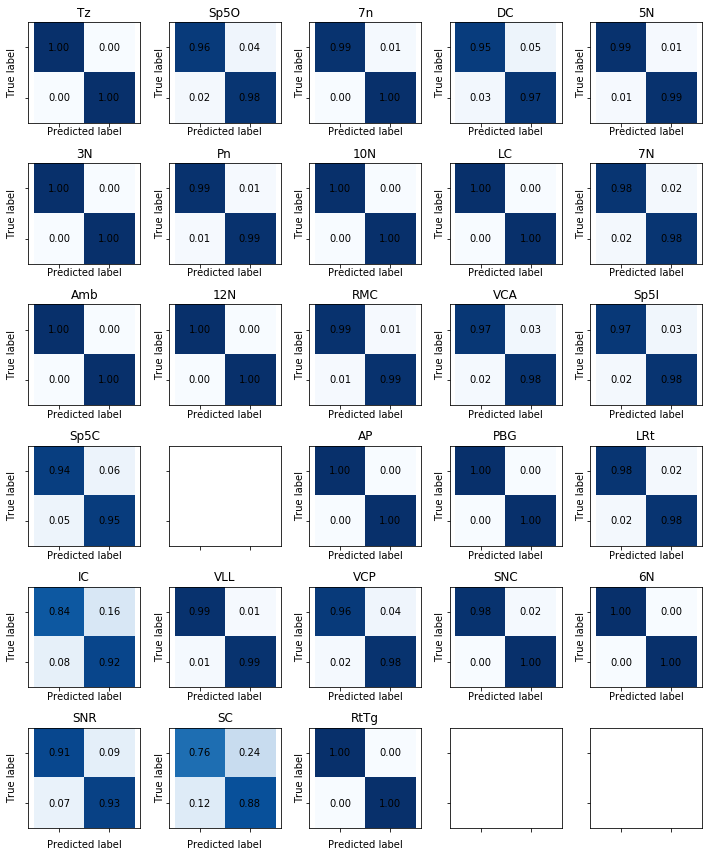

In [67]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    if structure not in training_features:
        continue
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 999]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:        
        raise Exception('Setting is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_yt[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [68]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.97677824485
